# Bayesian Multi-level Modelling

In this notebook, I will demonstrate how to use Bayesian multi-level models to share information between similar groups to achieve more realistic predictions. 

This will be done by sharing knowledge between groups. In particular, smaller groups will tend to be guided towards the mean of the whole dataset. This will help reduce outlier effects when there are only a few data points in a group.


References:
- https://docs.pymc.io/notebooks/multilevel_modeling.html
- https://twiecki.io/blog/2014/03/17/bayesian-glms-3/
- http://www.stat.columbia.edu/~gelman/research/published/multi2.pdf
- https://docs.pymc.io/notebooks/Diagnosing_biased_Inference_with_Divergences.html

In [1]:
from multilevel_regression import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', 100, 'display.max_rows', 100)

# 1. Load data

In [2]:
def get_data():
    # load data
    srrs2 = pd.read_csv(pm.get_data('srrs2.dat'))
    srrs2.columns = srrs2.columns.map(str.strip)
    srrs2['county'] = srrs2['county'].str.strip()
    srrs_mn = srrs2.loc[srrs2.state == 'MN', :].copy()
    srrs_mn['fips'] = srrs_mn.stfips * 1000 + srrs_mn.cntyfips

    cty = pd.read_csv(pm.get_data('cty.dat'))
    cty_mn = cty.loc[cty.st == 'MN', :].copy()
    cty_mn['fips'] = cty_mn.stfips * 1000 + cty_mn.ctfips

    srrs_mn = srrs_mn.merge(cty_mn[['fips', 'Uppm']], on='fips')

    # target (y)
    y = srrs_mn['activity'].values
    y_bc, lambda_bc = boxcox(y + 0.1)

    # predictor (x)
    x = srrs_mn['floor'].values

    # groups
    group = pd.Categorical(srrs_mn['county'])
    group_idx = group.codes

    return srrs_mn, x, y, y_bc, lambda_bc, group, group_idx

In [3]:
dataset, x, y, y_bc, lambda_bc, group, group_idx = get_data()

In [4]:
dataset.head()

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,windoor,rep,stratum,wave,starttm,stoptm,startdt,stopdt,activity,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm
0,5081,MN,MN,27,55735,5,1,1,3,N,,2,4,41,930,930,12088,12288,2.2,9.7,1146.499190,1,0,1,AITKIN,27001,0.502054
1,5082,MN,MN,27,55748,5,1,0,4,Y,,5,2,40,1615,1615,11888,12088,2.2,14.5,471.366223,0,0,1,AITKIN,27001,0.502054
2,5083,MN,MN,27,55748,5,1,0,4,Y,,3,2,42,1030,1515,20288,21188,2.9,9.6,433.316718,0,0,1,AITKIN,27001,0.502054
3,5084,MN,MN,27,56469,5,1,0,4,Y,,2,2,24,1410,1410,122987,123187,1.0,24.3,461.623670,0,0,1,AITKIN,27001,0.502054
4,5085,MN,MN,27,55011,3,1,0,4,Y,,3,2,40,600,600,12888,13088,3.1,13.8,433.316718,0,0,3,ANOKA,27003,0.428565


We can see from the bar chart below that there are a few counties with sufficient amount of data points to train a regression model; while most of them only have <10 data points. **The task here is to share/transfer knowledge from the whole dataset to the smaller groups.**

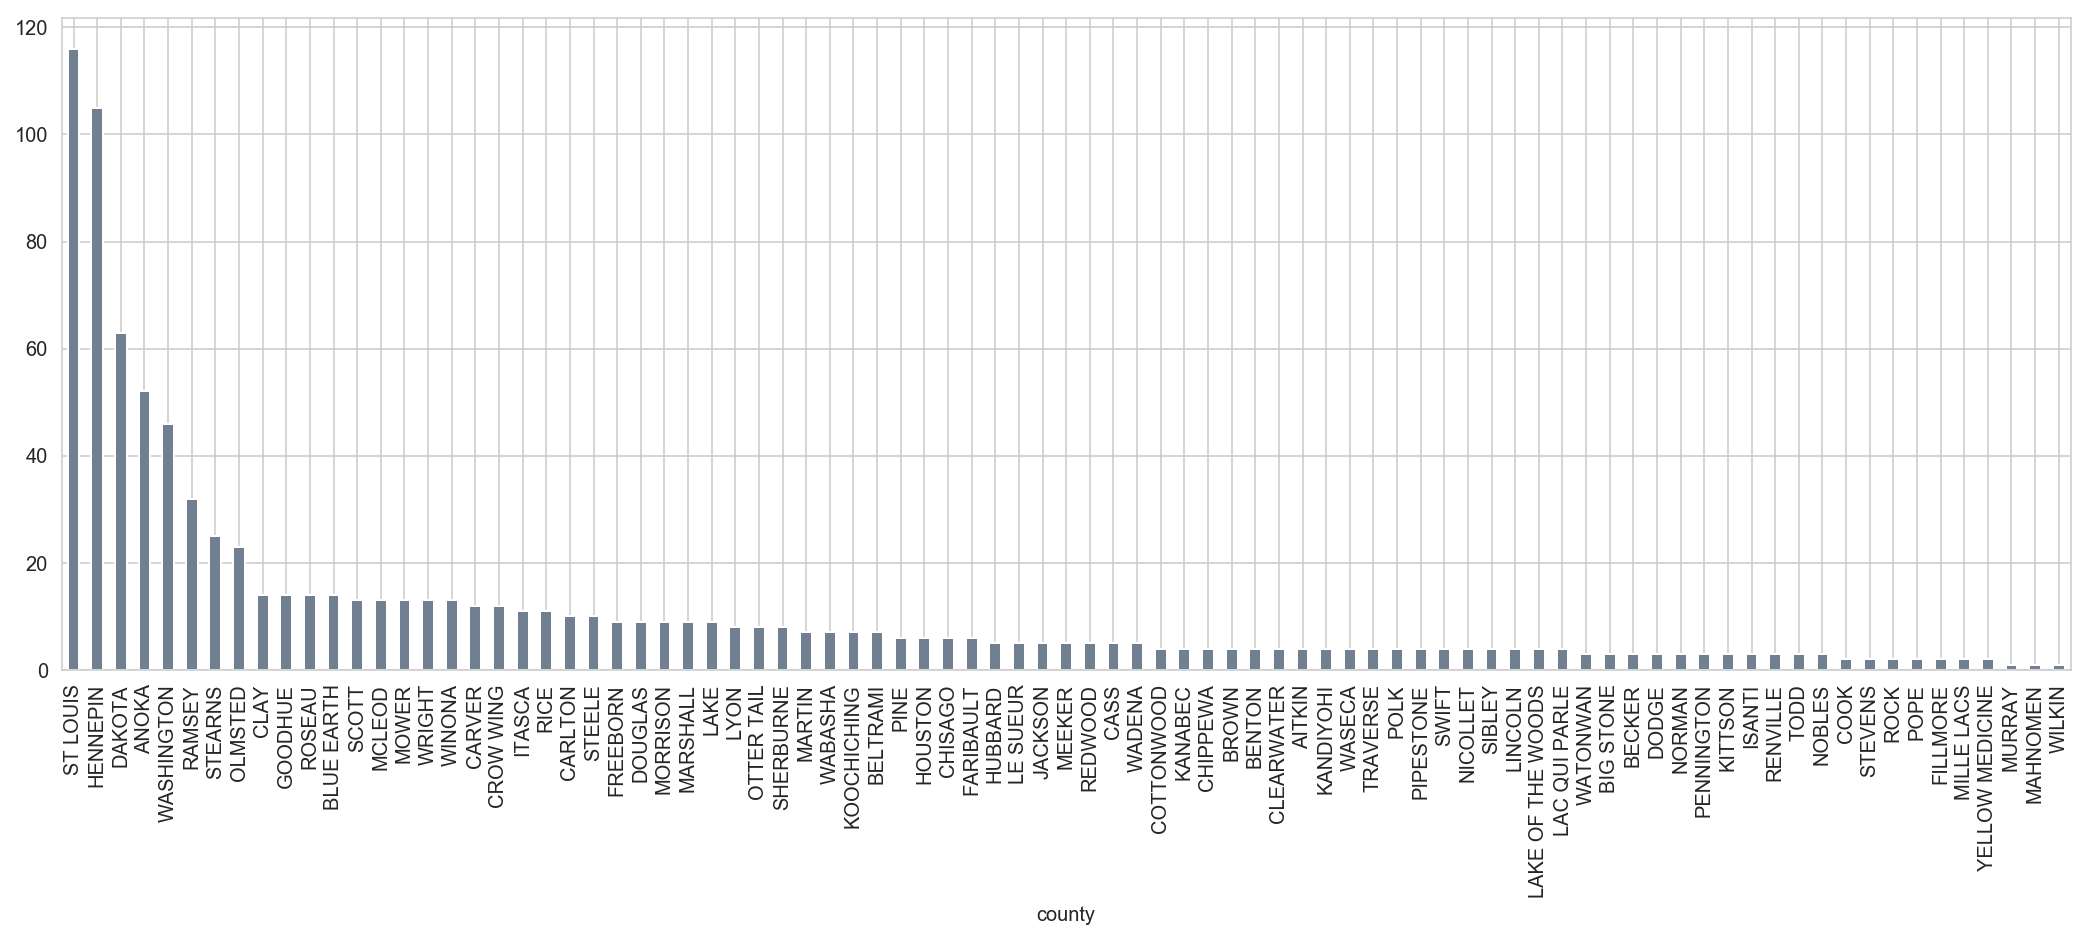

In [5]:
dataset.groupby('county', sort=False).size()\
       .sort_values(ascending=False)\
       .plot(kind='bar', figsize=(18, 6), color='slategrey');

We can see that in the figure below the radon activity follows roughly a lognormal distribution. To make modelling easier, box-cox transform is used to make the distribution more "normal".

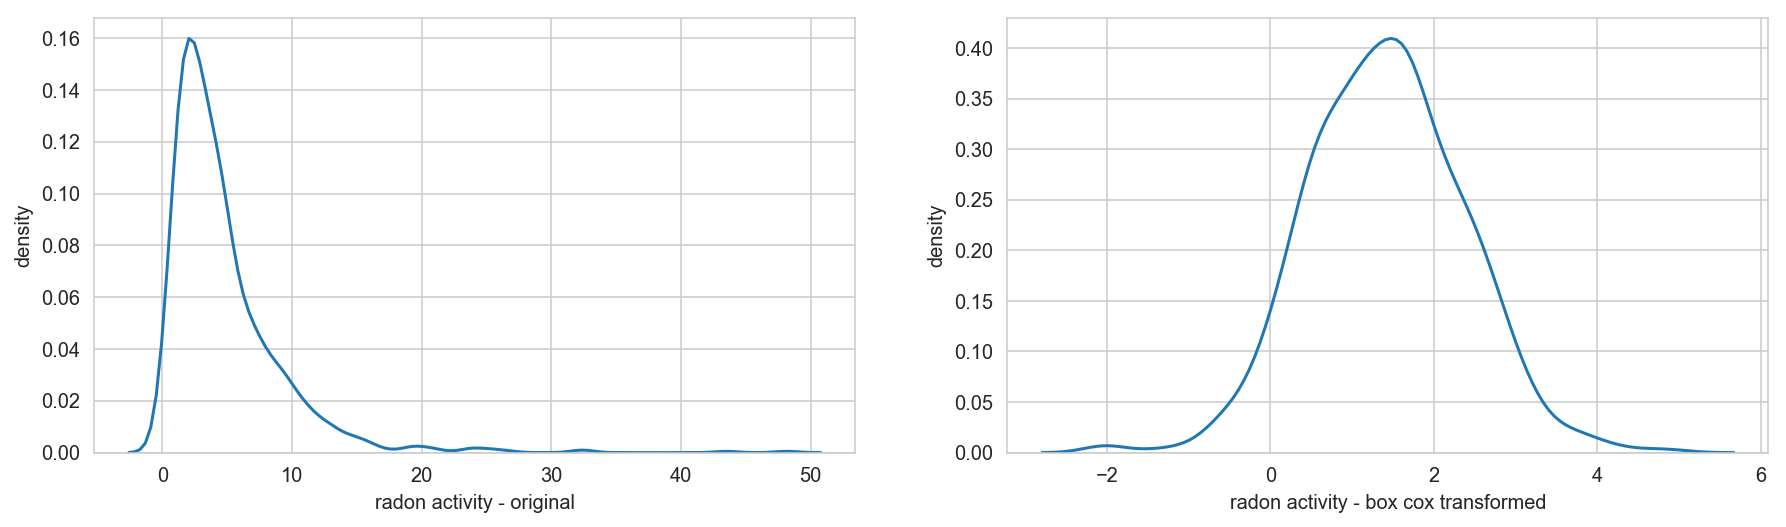

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
sns.kdeplot(y, ax=ax[0])
ax[0].set_ylabel('density')
ax[0].set_xlabel('radon activity - original')

sns.kdeplot(y_bc, ax=ax[1])
ax[1].set_ylabel('density')
ax[1].set_xlabel('radon activity - box cox transformed')

plt.show()

# 2. Total pooling

Here I demonstrate what predictions look like if we ignore the groups (counties) and treat the whole dataset as one group.

In [11]:
pooled_model = PoolLinearModel()
pooled_model.fit(x, y_bc, draws=3000, tune=2000, chains=4, cores=4, target_accept=.9, burn=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, beta, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:21<00:00, 945.57draws/s] 


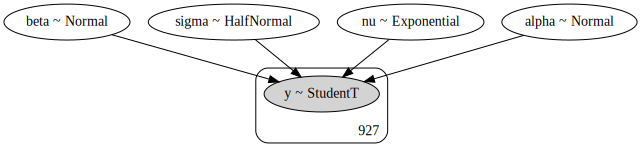

In [12]:
pm.model_to_graphviz(pooled_model.model_)

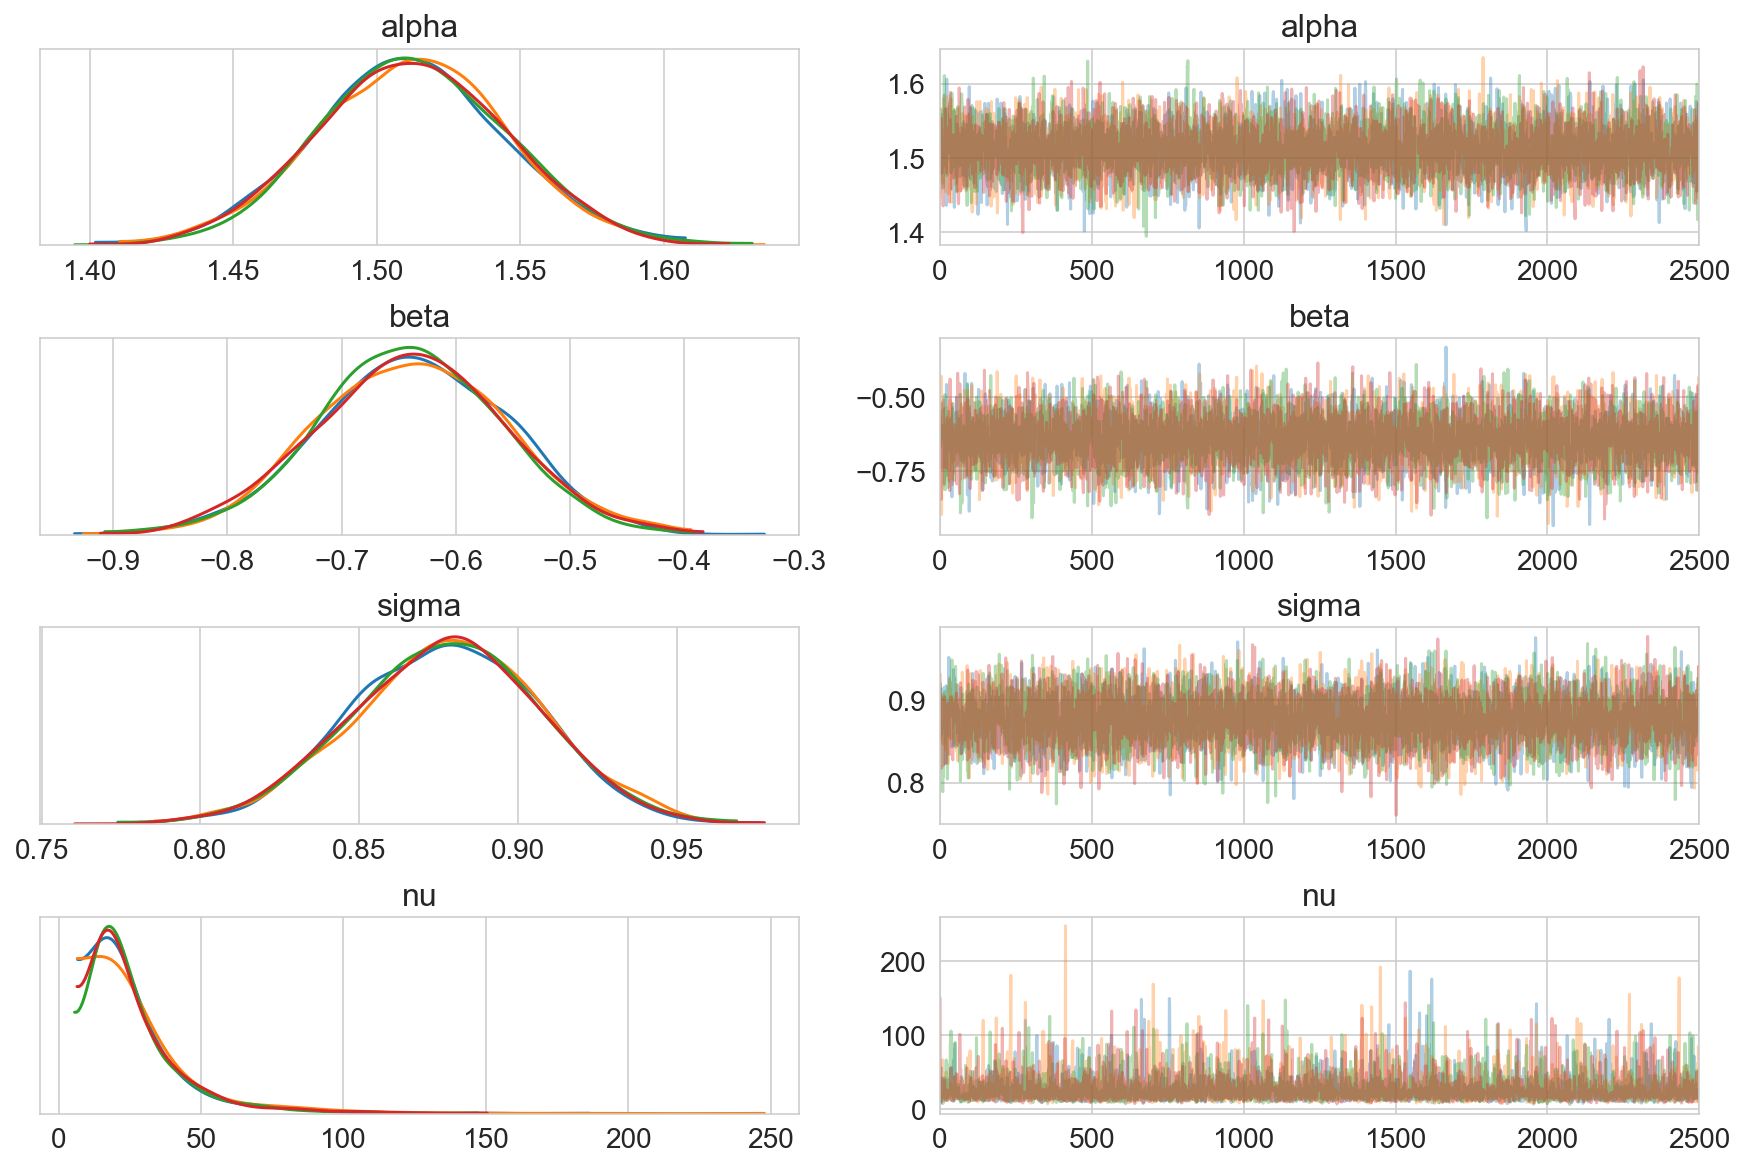

In [13]:
_ = pm.traceplot(pooled_model.trace_)

In [14]:
x_ = np.linspace(x.min(), x.max(), 20)
_, y_pred_pool = pooled_model.predict(x_, q=(0.025, 0.5, 0.975))

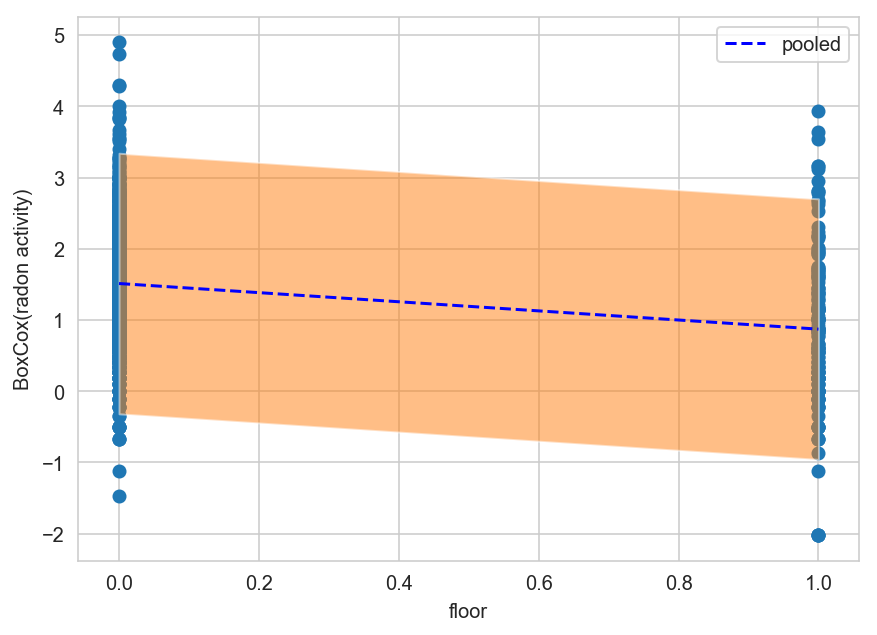

In [15]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(x, y_bc)
plot_prediction(x_, y_mean=y_pred_pool[1], y_upper=y_pred_pool[0], y_lower=y_pred_pool[2], 
                xlabel='floor', ylabel='BoxCox(radon activity)',ax=ax, linestyle='--', 
                c='b', label='pooled')
plt.show()

# 3. No pooling

Here I demonstrate the other extreme scenario where groups are treated as independent and unrelated entities. 

One of the problems is that we cannot fit a line if there is only one data point (obviously).

In [16]:
unpooled_model = UnpoolLinearModel()
unpooled_model.fit(x, y_bc, draws=3000, tune=2000, chains=4, cores=4,
                   target_accept=.9, burn=500, group_idx=group_idx)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, beta, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:49<00:00, 402.46draws/s]


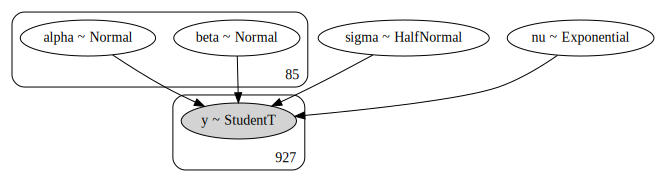

In [17]:
pm.model_to_graphviz(unpooled_model.model_)

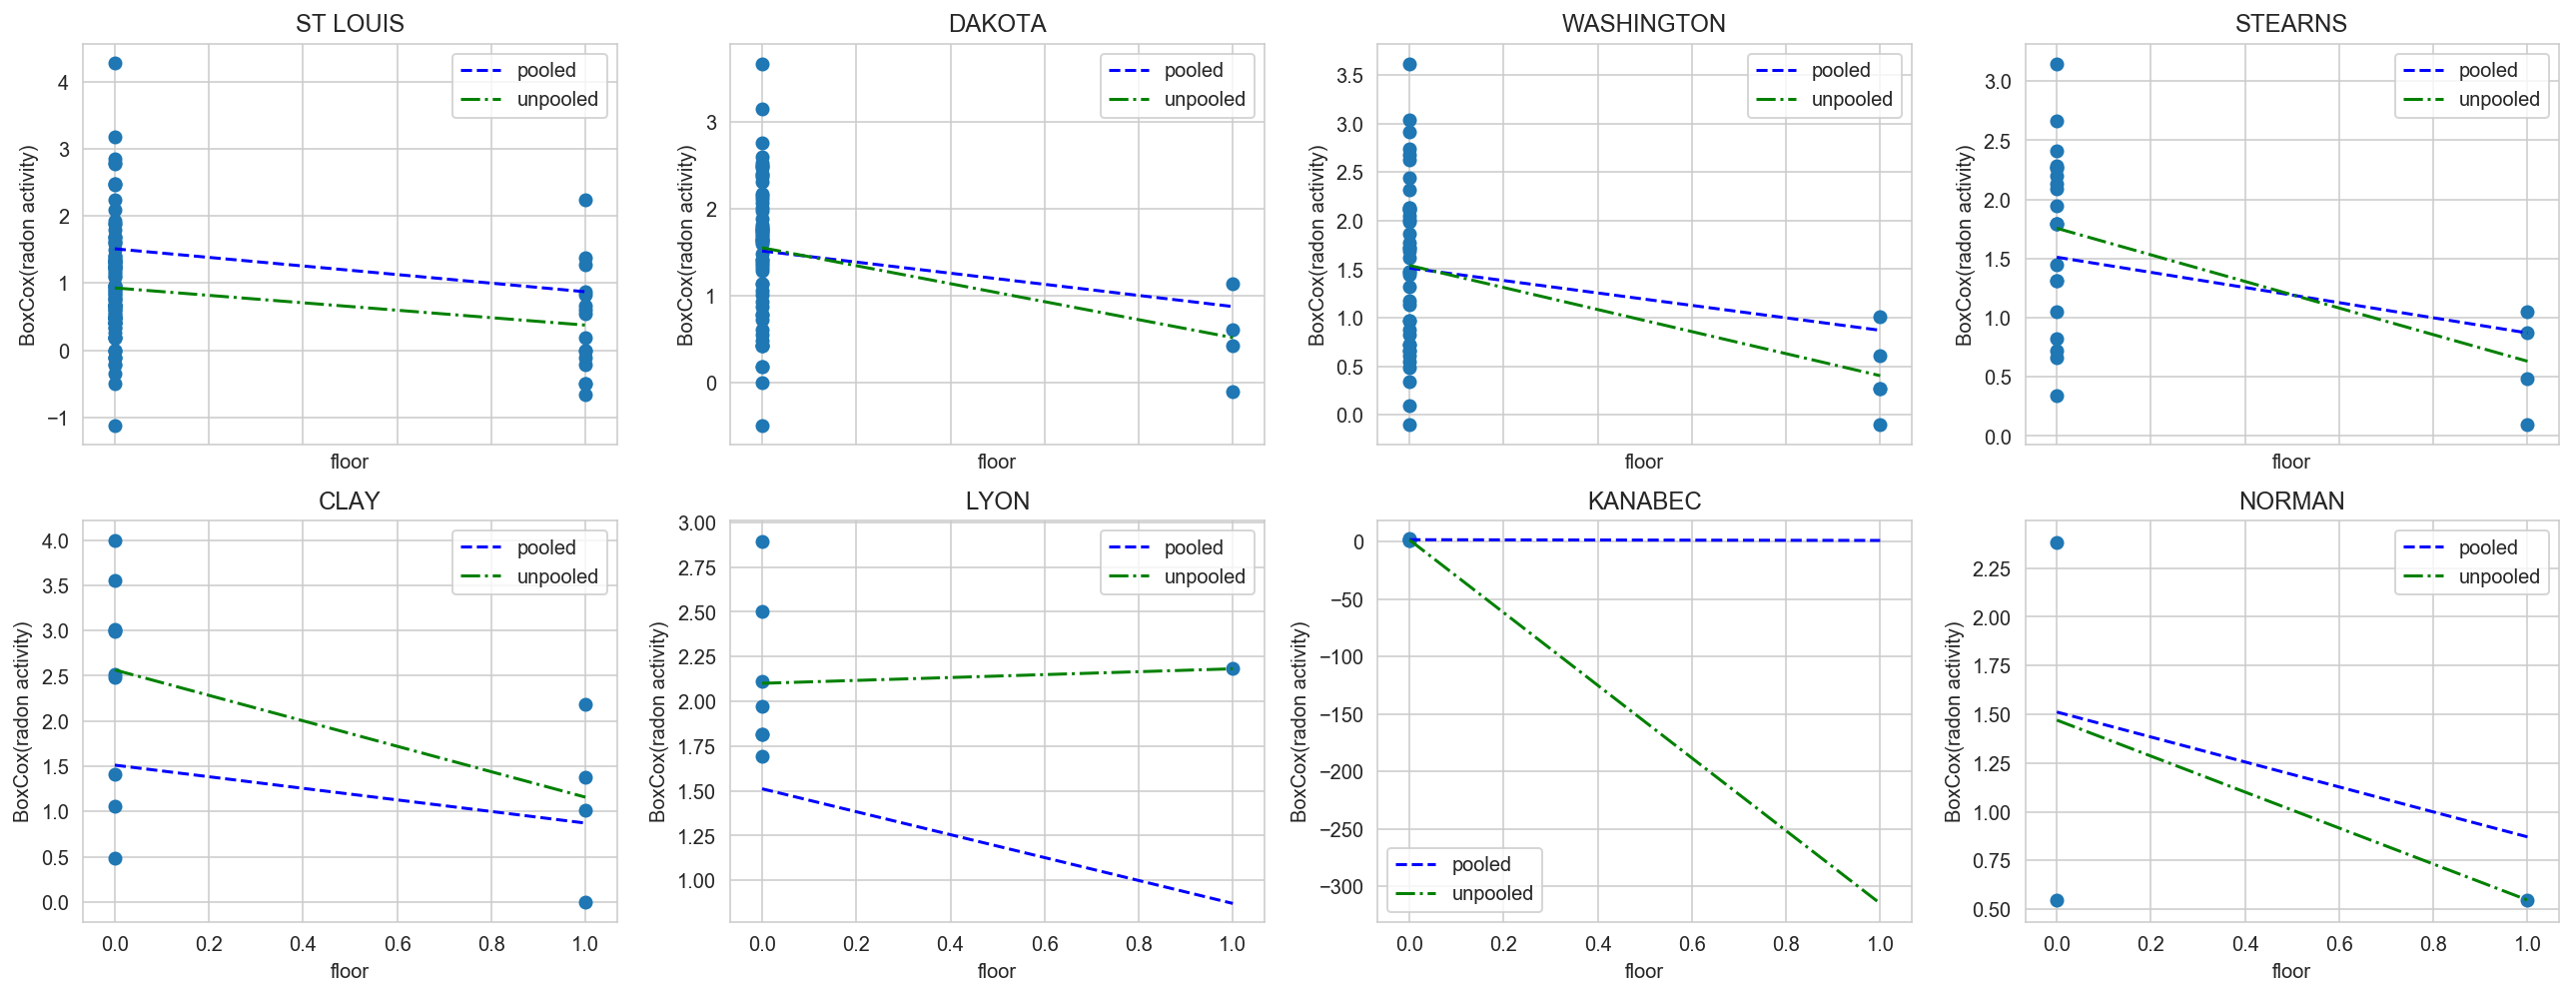

In [18]:
fig, ax = plt.subplots(2, 4, figsize=(18, 7), sharex=True)
ax_ = ax.ravel()
x_ = np.linspace(x.min(), x.max(), 20)
selected_groups = ['ST LOUIS', 'DAKOTA', 'WASHINGTON', 'STEARNS', 'CLAY', 'LYON', 'KANABEC', 'NORMAN']

for i, g in enumerate(selected_groups):
    # plot observed data points
    mask = dataset['county'] == g
    ax_[i].scatter(x[mask], y_bc[mask])
    ax_[i].set_title(g)
    j = np.where(group.categories == g)[0][0]
    
    # compare pooled and unpooled models
    # pooled model
    plot_prediction(x_, y_mean=y_pred_pool[1], y_upper=None, y_lower=None, 
                    xlabel='floor', ylabel='BoxCox(radon activity)',ax=ax_[i], linestyle='--', 
                    c='b', label='pooled')
    
    # unpooled model
    _, y_pred_unpool = unpooled_model.predict(x_, q=(0.025, 0.5, 0.975), group_idx=j)
    plot_prediction(x_, y_mean=y_pred_unpool[1], y_upper=None, y_lower=None, 
                    xlabel='floor', ylabel='BoxCox(radon activity)', ax=ax_[i], 
                    linestyle='-.', c='g', label='unpooled')
    
    
fig.tight_layout()
plt.show()

# 4. Partial pooling

With Bayesian multi-level modelling we can do something in-between total pooling and no pooling - partial pooling.

**Each group still has its own priors, but the group priors will all share the same hyper-priors. Through these hyper-priors, information can be shared between the groups.**

In [19]:
partial_pooled_model = PartialPoolLinearModel()
partial_pooled_model.fit(x, y_bc, draws=30000, tune=7000, chains=4, cores=4,
                         target_accept=.9, burn=500, group_idx=group_idx)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, beta_t, beta_sigma, beta_mu, alpha_t, alpha_sigma, alpha_mu]
Sampling 4 chains: 100%|██████████| 148000/148000 [06:50<00:00, 360.59draws/s]
The number of effective samples is smaller than 25% for some parameters.


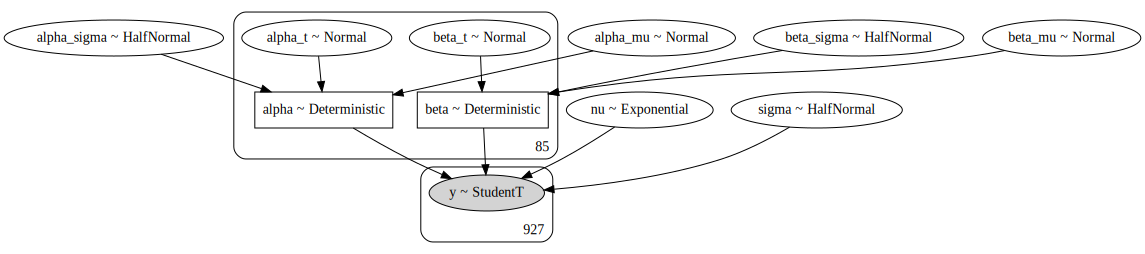

In [20]:
pm.model_to_graphviz(partial_pooled_model.model_)

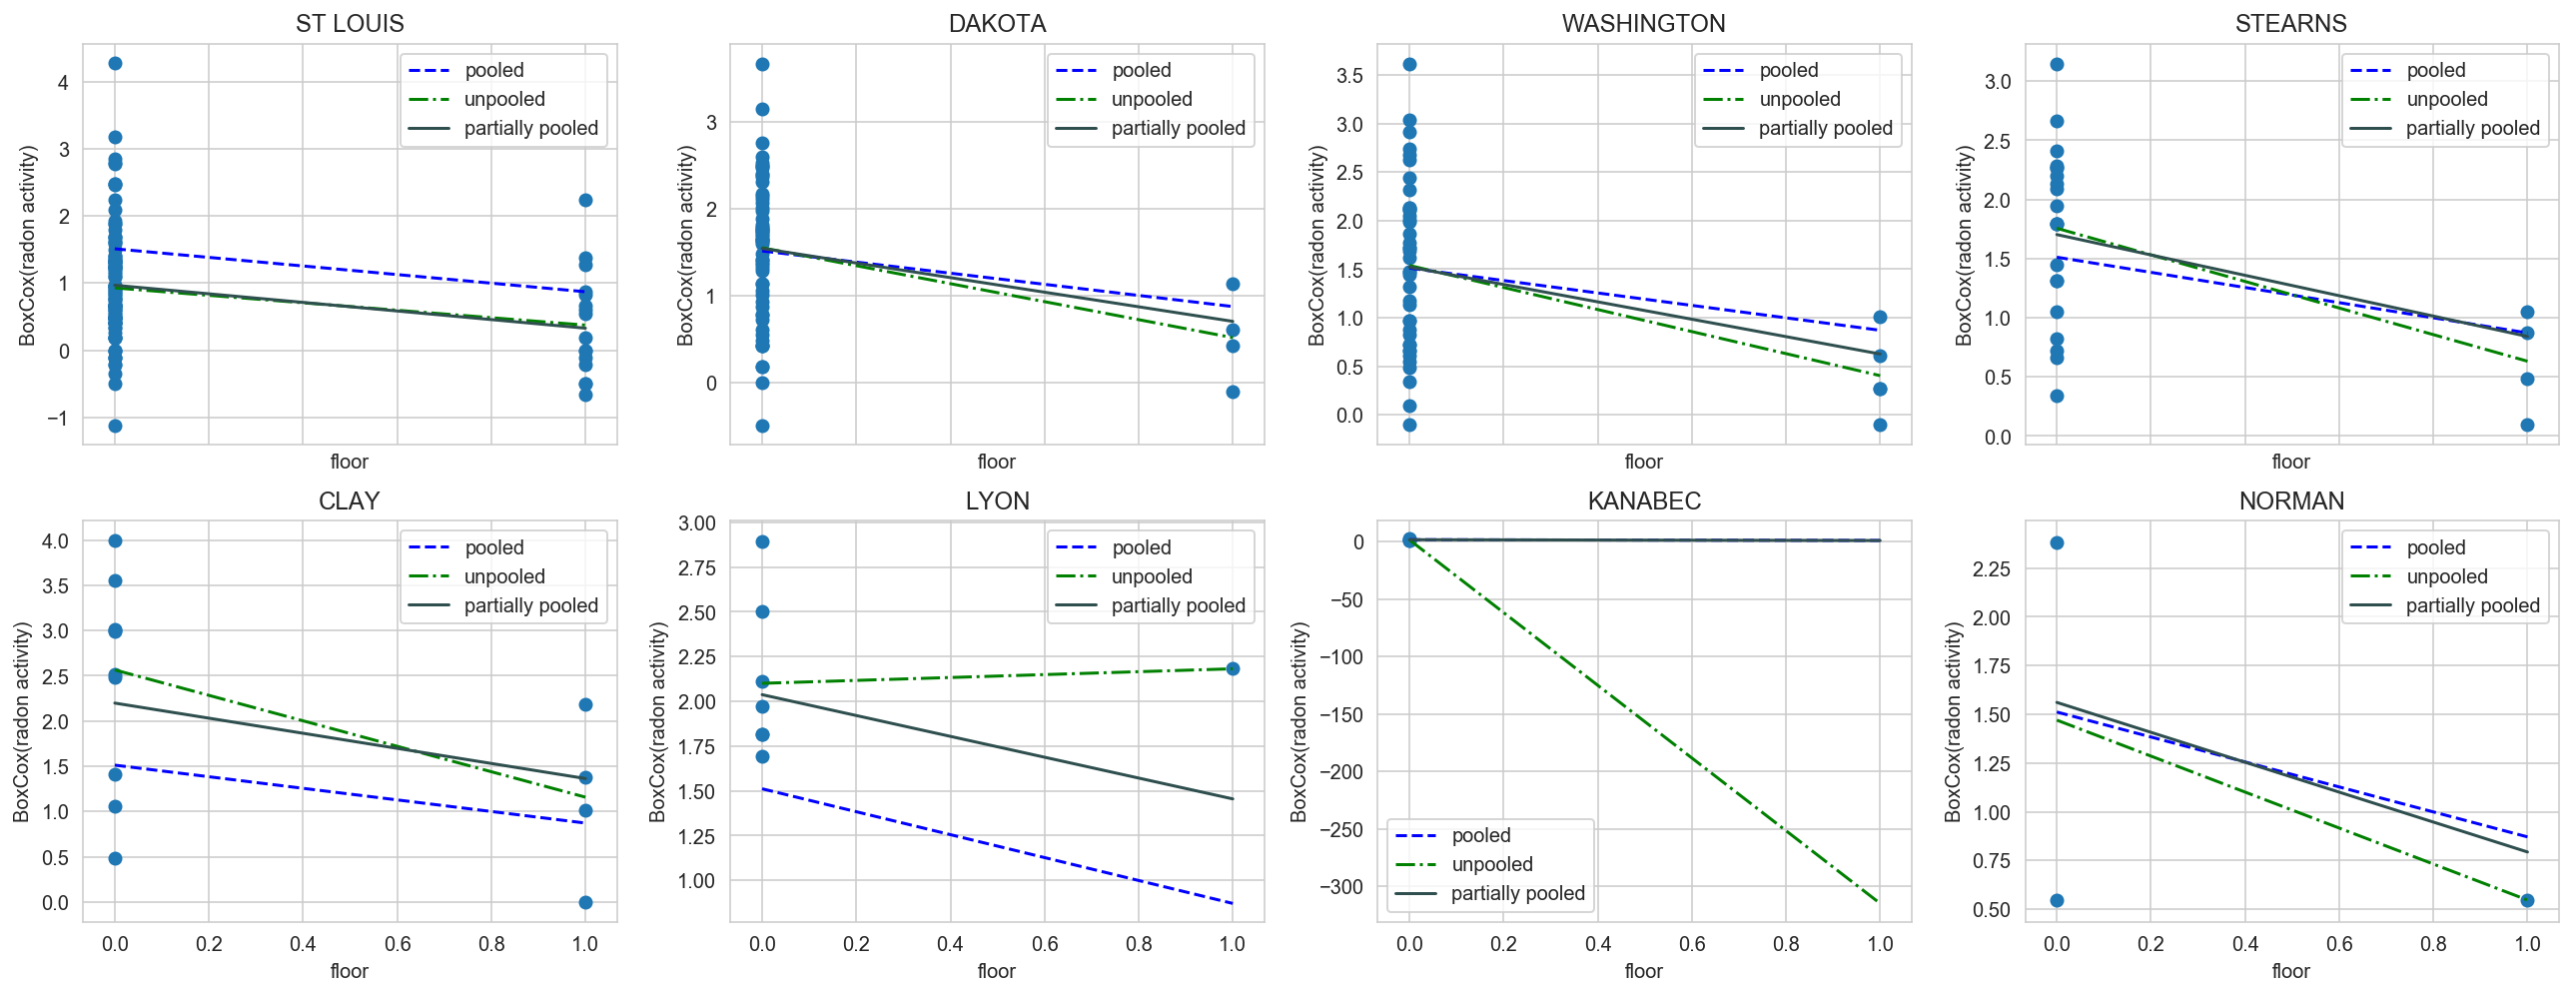

In [21]:
fig, ax = plt.subplots(2, 4, figsize=(18, 7), sharex=True)
ax_ = ax.ravel()
x_ = np.linspace(x.min(), x.max(), 20)
selected_groups = ['ST LOUIS', 'DAKOTA', 'WASHINGTON', 'STEARNS', 'CLAY', 'LYON', 'KANABEC', 'NORMAN']

for i, g in enumerate(selected_groups):
    # plot observed data points
    mask = dataset['county'] == g
    ax_[i].scatter(x[mask], y_bc[mask])
    ax_[i].set_title(g)
    j = np.where(group.categories == g)[0][0]
    
    # compare pooled, unpooled and partially pooled models
    # pooled model
    plot_prediction(x_, y_mean=y_pred_pool[1], y_upper=None, y_lower=None, 
                    xlabel='floor', ylabel='BoxCox(radon activity)',ax=ax_[i], linestyle='--', 
                    c='b', label='pooled')
    
    # unpooled model
    _, y_pred_unpool = unpooled_model.predict(x_, q=(0.025, 0.5, 0.975), group_idx=j)
    plot_prediction(x_, y_mean=y_pred_unpool[1], y_upper=None, y_lower=None, 
                    xlabel='floor', ylabel='BoxCox(radon activity)', ax=ax_[i], 
                    linestyle='-.', c='g', label='unpooled')
    
    # partially pooled model
    _, y_pred_partial_pool = partial_pooled_model.predict(x_, q=(0.025, 0.5, 0.975), group_idx=j)
    plot_prediction(x_, y_mean=y_pred_partial_pool[1], y_upper=None, y_lower=None, 
                    xlabel='floor', ylabel='BoxCox(radon activity)', ax=ax_[i], 
                    linestyle='-', c='darkslategrey', label='partially pooled')
    
fig.tight_layout()
plt.show()

# 5. Discussion

One interesting plot is for Lyon county. The following figure plots the three methods in separate graphs with their credible intervals. 

We can see that with the total pooling method, the regression intercept is a bit too low for the data points which gives a bias to prediction.

On the other hand, with the no pooling method the regression slope is positive which is opposite to what we see in other groups.

With partial pooling method, we combine the knowledge we obtain from the wider group with the group specific data points. This produces a more "sensible" predictions for smaller groups in particular.

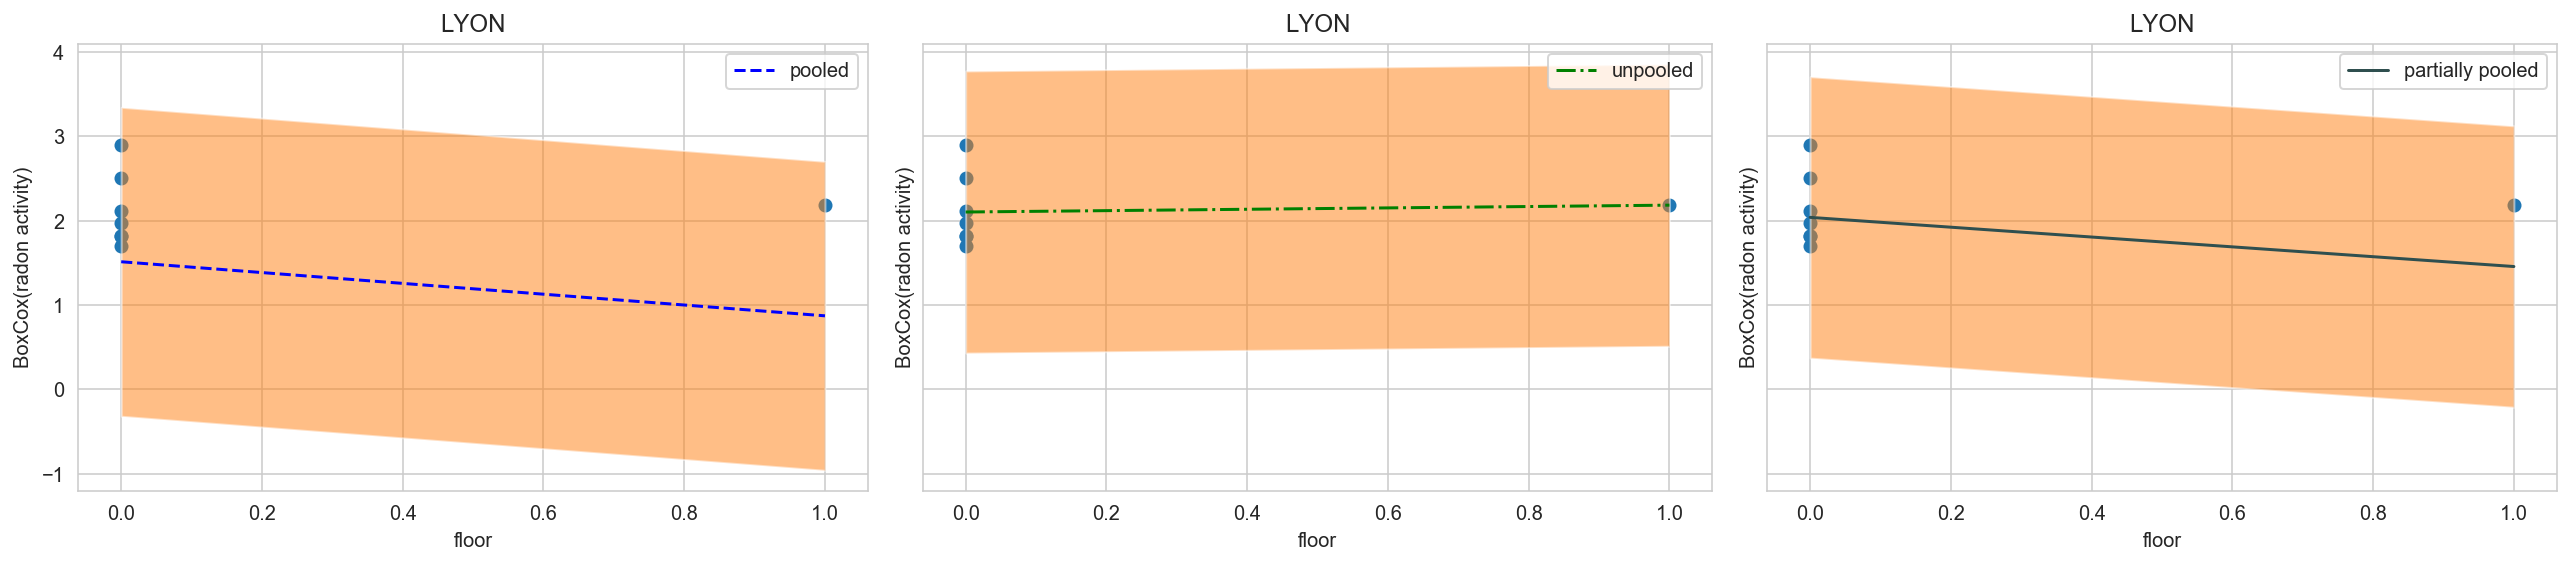

In [25]:
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(18, 4))

g = 'LYON'
mask = dataset['county'] == g
j = np.where(group.categories == g)[0][0]

for i in range(3):
    # plot observed data points
    ax[i].scatter(x[mask], y_bc[mask])
    ax[i].set_title(g)

# compare pooled, unpooled and partially pooled models
# pooled model
plot_prediction(x_, y_mean=y_pred_pool[1], y_upper=y_pred_pool[0], y_lower=y_pred_pool[2], 
                xlabel='floor', ylabel='BoxCox(radon activity)',ax=ax[0], linestyle='--', 
                c='b', label='pooled')

# unpooled model
_, y_pred_unpool = unpooled_model.predict(x_, q=(0.025, 0.5, 0.975), group_idx=j)
plot_prediction(x_, y_mean=y_pred_unpool[1], y_upper=y_pred_unpool[0], y_lower=y_pred_unpool[2], 
                xlabel='floor', ylabel='BoxCox(radon activity)', ax=ax[1], 
                linestyle='-.', c='g', label='unpooled')

# partially pooled model
_, y_pred_partial_pool = partial_pooled_model.predict(x_, q=(0.025, 0.5, 0.975), group_idx=j)
plot_prediction(x_, y_mean=y_pred_partial_pool[1], y_upper=y_pred_partial_pool[0], y_lower=y_pred_partial_pool[2], 
                xlabel='floor', ylabel='BoxCox(radon activity)', ax=ax[2], 
                linestyle='-', c='darkslategrey', label='partially pooled')

fig.tight_layout()
plt.show()

# 6. Cross validation

In this section, I will use cross validation to prove that partial pooling provides better prediction. The evaluation metric is RMSE.

A key consideration: If there is only one data point or if there are only data available in one of the floors, then unpooled method cannot create a regression model. Therefore in this cross validation, those groups are removed.

TO BE CONTINUED...